In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

d:\conv3d\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {
	'BATCH_SIZE': 5,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 20,
    'IMG_SIZE': 56
        }


src = 'D:/abnormal_detection_dataset/data_3000/'


# 이미지 읽기
def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

X = []
Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    X.append(img_read(src,file)/255.)
    Y.append(1) # nomal label : 1

# array로 데이터 변환
X = np.array(X)
Y = np.array(Y)

print('Normal shape:',np.shape(X))
print(X.shape)
print(Y.shape)

Normal shape: (3000, 56, 56)
(3000, 56, 56)
(3000,)


In [3]:
import sklearn
from sklearn.model_selection import train_test_split
print(X.shape)
print(Y.shape)
# Train set, Test set으로 나누기
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(np.shape(X_train))
print(np.shape(X_test))
print(X_train.shape)
print(Y_train.shape)
print(X.shape)
print(Y.shape)

(3000, 56, 56)
(3000,)
(2400, 56, 56)
(600, 56, 56)
(2400, 56, 56)
(2400,)
(3000, 56, 56)
(3000,)


In [4]:
X_train = torch.Tensor(X_train)

X_train = X_train.unsqueeze(dim=1)
print(X_train.shape) #torch.Size([2400, 1, 1, 56, 56])

print(X_train.shape)

X_test = torch.Tensor(X_test)
X_test = X_test.unsqueeze(dim=1)
print(X_test.shape)

Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)
# data.to(device), target.to(device)
# X_train, X_test, Y_train, Y_test = X_train.to(device), X_test.to(device), Y_train.to(device), Y_test.to(device)

torch.Size([2400, 1, 56, 56])
torch.Size([2400, 1, 56, 56])
torch.Size([600, 1, 56, 56])


In [5]:
# X_train = X_train.numpy()
# X_test = X_test.numpy()
# Y_train = Y_train.numpy()
# Y_test = Y_test.numpy()

In [6]:
# import sklearn
# from sklearn.model_selection import train_test_split
# print(X.shape)
# print(Y.shape)
# # Train set, Test set으로 나누기
# X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

# # 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# print(np.shape(X_train))
# print(np.shape(X_test))
# print(X_train.shape)
# print(Y_train.shape)
# print(X.shape)
# print(Y.shape)
# '''
# (3000, 56, 56)
# (3000,)
# (2400, 3136)
# (600, 3136)
# (2400, 3136)
# (2400,)
# (3000, 56, 56)
# (3000,)
# '''

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X_train
        self.Y = Y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        labels = self.Y[idx]
        return img, labels

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder # (args['BATCH_SIZE'], 1, args['IMG_SIZE'], args['IMG_SIZE'])
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output

In [8]:
train_dataset = CustomDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=0)

test_dataset = CustomDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=0)

model = ConvAutoEncoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

In [23]:
steps = 0
total_steps = len(train_loader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1

        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X_train.shape[0]

        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch + 1, args['NUM_EPOCH']),
                  'Training loss: {:.5f}..'.format(running_loss / total_steps))

            steps = 0
            running_loss = 0
            model.train()

torch.save(model.state_dict(), './ae.pth')

Epoch: 1/20 Training loss: 0.00135..
Epoch: 2/20 Training loss: 0.00131..
Epoch: 3/20 Training loss: 0.00133..
Epoch: 4/20 Training loss: 0.00124..
Epoch: 5/20 Training loss: 0.00124..
Epoch: 6/20 Training loss: 0.00122..
Epoch: 7/20 Training loss: 0.00117..
Epoch: 8/20 Training loss: 0.00116..
Epoch: 9/20 Training loss: 0.00115..
Epoch: 10/20 Training loss: 0.00113..
Epoch: 11/20 Training loss: 0.00111..
Epoch: 12/20 Training loss: 0.00108..
Epoch: 13/20 Training loss: 0.00110..
Epoch: 14/20 Training loss: 0.00106..
Epoch: 15/20 Training loss: 0.00106..
Epoch: 16/20 Training loss: 0.00103..
Epoch: 17/20 Training loss: 0.00104..
Epoch: 18/20 Training loss: 0.00102..
Epoch: 19/20 Training loss: 0.00101..
Epoch: 20/20 Training loss: 0.00100..


In [24]:
net = ConvAutoEncoder()
net.load_state_dict(torch.load('./ae.pth'))

print(net.parameters)

<bound method Module.parameters of ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)>


d:\conv3d\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([600, 1, 56, 56])) that is different to the input size (torch.Size([1, 56, 56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


valdation loss 116.88938903808594


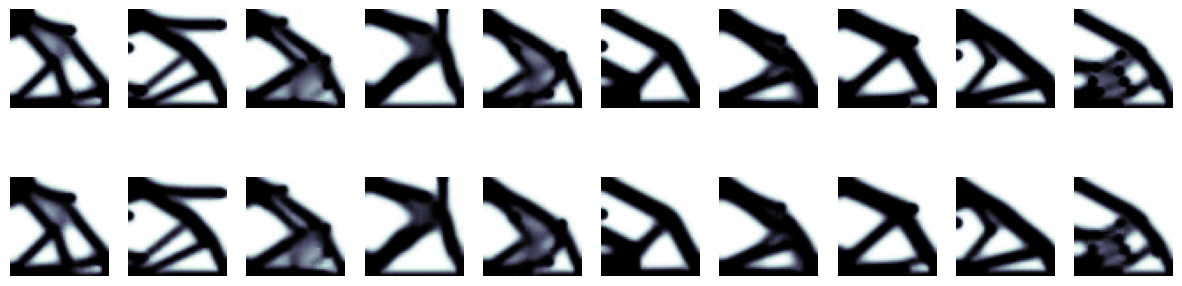

In [11]:
import matplotlib.pyplot as plt
preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in X_test:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, X_test)
        val_loss += v_loss
    print('valdation loss {}'.format(val_loss))


sample_size = 10

test_sample, pred_sample = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    for i in range(sample_size):
        

        val_input1 = X_test[i]
        for val_input1 in X_test:
            val_output1 = model(val_input1)
            test_sample.append(val_input1)
            pred_sample.append(val_output1)

            org_img1 = test_sample[i].reshape(56,56)
            rec_img1 = pred_sample[i].reshape(56,56)

            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()
            
            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()

In [13]:
from torchvision import models
from torchinfo import summary

summary(model)


Layer (type:depth-idx)                   Param #
ConvAutoEncoder                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-7              8,224
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─ConvTranspose2d: 2-9              129
│    └─Sigmoid: 2-10                     --
Total params: 27,169
Trainable params: 27,169
Non-trainable params: 0

In [18]:
import pandas as pd # pandas 라이브러리

# Normal data (data_3000)
Nom_data = np.concatenate((X_test, X_train), axis = 0)
# Nom_data = torch.Tensor(Nom_data)
# Nom_data.numpy()
Nom_pred = model(Nom_data) # AE 이미지 결과값 
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

print('\n')

# Abnormal data (data_1000)
ANom_pred = model(ANom_images) # AE 이미지 결과값 
ANom_pred_mse = np.mean(np.power(ANom_images - ANom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

# 히스토그램 그리기
print('\n')
plt.figure()
plt.title('MSE Histogram') # 그림 이름 설정 
plt.hist(Nom_pred_mse, bins=10, facecolor='blue', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.hist(ANom_pred_mse, bins=10, facecolor='red', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [20]:
test_path = 'D:/abnormal_detection_dataset/data_1000/'

def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(test_path)

test_X = []
test_Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    test_X.append(img_read(test_path,file)/255.)
    test_Y.append(1) # nomal label : 1

# array로 데이터 변환
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Normal shape:',np.shape(test_X))
print(test_X.shape)
print(test_Y.shape)

print(np.shape(test_X))
print(np.shape(test_Y))
print(test_X.shape)
print(test_Y.shape)

Normal shape: (1000, 56, 56)
(1000, 56, 56)
(1000,)
(1000, 56, 56)
(1000,)
(1000, 56, 56)
(1000,)


In [21]:
test_X = torch.Tensor(test_X)

test_X = test_X.unsqueeze(dim=1)
print(test_X.shape) #torch.Size([2400, 1, 1, 56, 56])

print(test_X.shape)


test_Y = torch.Tensor(test_Y)
print(test_Y.shape)

torch.Size([1000, 1, 56, 56])
torch.Size([1000, 1, 56, 56])
torch.Size([1000])


d:\conv3d\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1000, 1, 56, 56])) that is different to the input size (torch.Size([1, 56, 56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


valdation loss 231.22975158691406


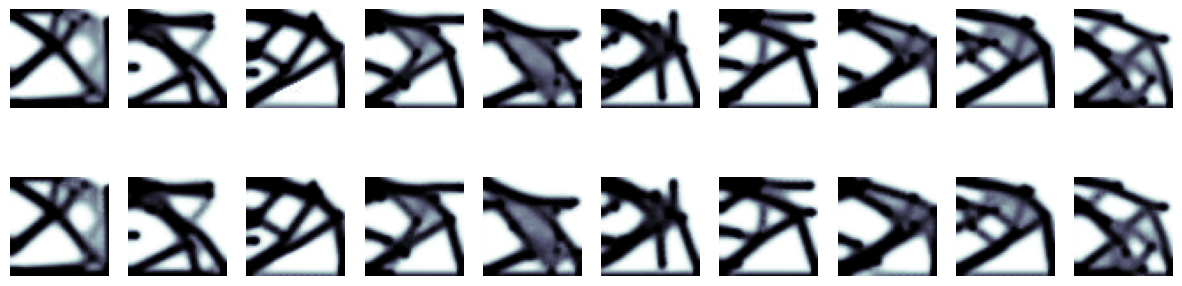

In [22]:
import matplotlib.pyplot as plt
preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in test_X:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, test_X)
        val_loss += v_loss
    print('valdation loss {}'.format(val_loss))


sample_size = 10

test_sample1, pred_sample1 = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    for i in range(sample_size):
        

        val_input1 = test_X[i]
        for val_input1 in test_X:
            val_output1 = model(val_input1)
            test_sample1.append(val_input1)
            pred_sample1.append(val_output1)

            org_img1 = test_sample1[i].reshape(56,56)
            rec_img1 = pred_sample1[i].reshape(56,56)

            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()
            
            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()

In [37]:
# -*- coding: utf-8 -*-
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in X_test, Y_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('ori', 'recon')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

ModuleNotFoundError: No module named 'seaborn'

In [36]:
# -*- coding: utf-8 -*-
pip install seaborn

SyntaxError: invalid syntax (1075681937.py, line 2)

In [40]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import sklearn
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


args = {
	'BATCH_SIZE': 5,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 20,
    'IMG_SIZE': 700
        }

In [41]:
src = 'D:/abnormal_detection_dataset/mvtec_anomaly_detection/metal_nut/train/good/'


# 이미지 읽기
def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

X = []
Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    X.append(img_read(src,file)/255.)
    Y.append(1) # nomal label : 1

# array로 데이터 변환
X = np.array(X)
Y = np.array(Y)

print('Normal shape:',np.shape(X))
print(X.shape)
print(Y.shape)



print(X.shape)
print(Y.shape)
# Train set, Test set으로 나누기
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(np.shape(X_train))
print(np.shape(X_test))
print(X_train.shape)
print(Y_train.shape)
print(X.shape)
print(Y.shape)

Normal shape: (220, 700, 700, 3)
(220, 700, 700, 3)
(220,)
(220, 700, 700, 3)
(220,)
(176, 700, 700, 3)
(44, 700, 700, 3)
(176, 700, 700, 3)
(176,)
(220, 700, 700, 3)
(220,)


In [42]:
X_train = torch.Tensor(X_train)

print(X_train.shape) #torch.Size([2400, 1, 1, 56, 56])

print(X_train.shape)

X_test = torch.Tensor(X_test)

print(X_test.shape)

Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

torch.Size([176, 700, 700, 3])
torch.Size([176, 700, 700, 3])
torch.Size([44, 700, 700, 3])


In [43]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X_train
        self.Y = Y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        labels = self.Y[idx]
        return img, labels

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder # (args['BATCH_SIZE'], 1, args['IMG_SIZE'], args['IMG_SIZE'])
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output

In [44]:
train_dataset = CustomDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=0)

test_dataset = CustomDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=0)

model = ConvAutoEncoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])


from torchvision import models
from torchinfo import summary

# summary(model)

Layer (type:depth-idx)                   Param #
ConvAutoEncoder                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-7              8,224
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─ConvTranspose2d: 2-9              129
│    └─Sigmoid: 2-10                     --
Total params: 27,169
Trainable params: 27,169
Non-trainable params: 0

In [45]:
steps = 0
total_steps = len(train_loader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1

        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X_train.shape[0]

        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch + 1, args['NUM_EPOCH']),
                  'Training loss: {:.5f}..'.format(running_loss / total_steps))

            steps = 0
            running_loss = 0
            model.train()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[5, 700, 700, 3] to have 1 channels, but got 700 channels instead

In [39]:


torch.save(model.state_dict(), './ae1.pth')

net = ConvAutoEncoder()
net.load_state_dict(torch.load('./ae1.pth'))

print(net.parameters)

import matplotlib.pyplot as plt

preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in X_test:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, X_test)
        val_loss += v_loss
    print('valdation loss {}'.format(val_loss))

sample_size = 10

test_sample, pred_sample = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    plt.title('reconstruct')
    for i in range(sample_size):

        val_input1 = X_test[i]
        for val_input1 in X_test:
            val_output1 = model(val_input1)
            test_sample.append(val_input1)
            pred_sample.append(val_output1)

            org_img1 = test_sample[i].reshape(700, 700)
            rec_img1 = pred_sample[i].reshape(700, 700)

            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()



#### 다른 데이터셋으로 테스ㅡㅌ
test_path = 'D:/abnormal_detection_dataset/mvtec_anomaly_detection/metal_nut/test/custom/'

def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(test_path)

test_X = []
test_Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    test_X.append(img_read(test_path,file)/255.)
    test_Y.append(1) # nomal label : 1

# array로 데이터 변환
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Normal shape:',np.shape(test_X))
print(test_X.shape)
print(test_Y.shape)

print(np.shape(test_X))
print(np.shape(test_Y))
print(test_X.shape)
print(test_Y.shape)


test_X = torch.Tensor(test_X)

# test_X = test_X.unsqueeze(dim=1)
print(test_X.shape) #torch.Size([2400, 1, 1, 56, 56])

print(test_X.shape)


test_Y = torch.Tensor(test_Y)
print(test_Y.shape)

import matplotlib.pyplot as plt

preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in test_X:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, test_X)
        val_loss += v_loss
    print('valdation loss {}'.format(val_loss))

sample_size = 10

test_sample1, pred_sample1 = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    for i in range(sample_size):

        val_input1 = test_X[i]
        for val_input1 in test_X:
            val_output1 = model(val_input1)
            test_sample1.append(val_input1)
            pred_sample1.append(val_output1)

            org_img1 = test_sample1[i].reshape(700, 700)
            rec_img1 = pred_sample1[i].reshape(700, 700)

            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()

Normal shape: (220, 700, 700, 3)
(220, 700, 700, 3)
(220,)
(220, 700, 700, 3)
(220,)
(176, 700, 700, 3)
(44, 700, 700, 3)
(176, 700, 700, 3)
(176,)
(220, 700, 700, 3)
(220,)
torch.Size([176, 700, 700, 3])
torch.Size([176, 700, 700, 3])
torch.Size([44, 700, 700, 3])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[5, 700, 700, 3] to have 1 channels, but got 700 channels instead